# 03-Stumps, trees and forests

** Ecole Centrale Nantes **

** Diana Mateus **

PARTICIPANTS: **(Fill in your names)**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## 1. Decision stumps
A decision stump is a machine learning model consisting of a one-level decision tree. That is, it is a decision tree with one internal node (the root) which is immediately connected to the terminal nodes (its leaves). A decision stump makes a prediction based on the value of just a single input feature. Sometimes they are also called 1-rules [Wikipedia]

***a)*** Run the provided code to generate and plot a toy dataset consisting of 2D points and 4 classes



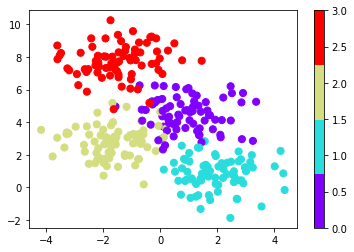

In [2]:
#a) Load and plot dataset, split in train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_classes = 4
X, y = make_blobs(n_samples=300, centers=n_classes,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.get_cmap('rainbow', 4));
plt.colorbar();

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)




**b)** Observe the functions **stump** and **split**. 

**stump** is a function that generates the parameters of a random axis-aligned split  according to the number of features of a given dataset. The function receives the data matrix Xtrain and returns
    - the index of one randomly chosen feature (one dimension) 
    - as well as a randomly chosen threshold within the min and max values of the chosen feature.

**split**  receives as input:
    - A dataset of points
    - the parameters generated by the stump function above. 
The function then partitions the *dataset* in two subsets according to the threshold of the chosen dimension.
The output are two arrays, each containing the _indices_ of the points belonging to one or the other subset. 

**c)** Run the split function **several times**, and display the resulting subsets as 2D scatter plots with circles of different colors for each class. Use the provided plotting functions.

Stump parameters 1 4.30664057647766
Sizes: original set: 225  left subset: (132,)  right subset: (93,)
Stump parameters 0 0.09279892307189552
Sizes: original set: 225  left subset: (123,)  right subset: (102,)
Stump parameters 1 1.1153945947141506
Sizes: original set: 225  left subset: (33,)  right subset: (192,)
Stump parameters 0 2.2676543017264974
Sizes: original set: 225  left subset: (204,)  right subset: (21,)
Stump parameters 1 0.4592998435722506
Sizes: original set: 225  left subset: (16,)  right subset: (209,)


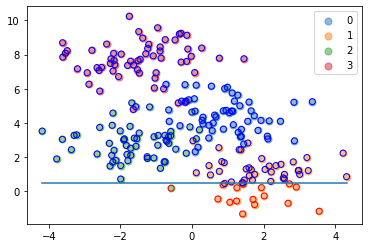

In [3]:
from random import randint, uniform

# b) Stumps and Split

def stump(X):
    f = randint(0, X.shape[1]-1) #randomly select a feature/dimension randint()
    t = uniform(np.min(X[:,f]),np.max(X[:,f])) #sample from an uniform() between the min and max values of the feature
    return f,t 


def split(X, f, t):
    ind_l, = np.where(X[:,f]<=t)
    ind_r, = np.where(X[:,f]>t)
    return ind_l, ind_r

# c) Plotting a stump

def plot_stump (Xtrain,ytrain,feat,th,ind_l,ind_r):
    n_classes=np.max(ytrain)+1;
    #print(n_classes)
    for c in range(n_classes):
        X0_c=Xtrain[np.where(ytrain==c), 0] #first coordinate of points belonging to class c
        X1_c=Xtrain[np.where(ytrain==c), 1] #second coordinate of points belonging to class c
        plt.scatter(X0_c,X1_c, s=50,alpha=0.5,cmap=plt.cm.get_cmap('rainbow', 4),label=str(c))

    #plt.axis('equal')

    #draw the points on the left and right child as circles around the original training dataset
    plt.scatter(Xtrain[ind_l, 0], Xtrain[ind_l, 1], c='none', edgecolor='r')
    plt.scatter(Xtrain[ind_r, 0], Xtrain[ind_r, 1], c='none', edgecolor='b')

    #draw threshold line
    if feat == 0:
        plt.plot([th,th],[np.min(Xtrain[:,1]),np.max(Xtrain[:,1])])
    elif feat == 1:
        plt.plot([np.min(Xtrain[:,0]),np.max(Xtrain[:,0])],[th,th])
    leg = plt.legend();

n_stumps = 5
for _ in range(n_stumps):
    feat, th = stump(Xtrain)
    print('Stump parameters', feat, th)
    ind_l,ind_r = split(Xtrain, feat, th)
    print('Sizes: original set:', len(ytrain), 
          ' left subset:' ,  ind_l.shape,
          ' right subset:', ind_r.shape)

plot_stump(Xtrain,ytrain,feat,th,ind_l,ind_r)


**d)** Implement a function ***class_distributions*** that given a set of points reaching a node returns the posterior class distribution of the node (approximated as the normalized histogram with #points per class).

``` python
def class_distributions(ytrain,ind_left, ind_right):
```

Compute the class distributions of:
    - of the original training set (before the split), 
    - of each of the 2 subsets resulting from after the split has been applied.

Plot the histograms of the children nodes

**e)** Create a function to compute the ***information_gain*** of a split. The function should receive the full training dataset (Xtrain and ytrain) and the indices of two subsets resulting from the current split. 

``` python
def information_gain(ytrain,ind_left, ind_right):
```
```Hint: ```  when computing the Entropy, ignore the classes with zero probabilities, and carry on summation using the same equation.


In [4]:
def class_distributions(ytrain, ind_left, ind_right):
    left_distribution=[len(np.where(ytrain[ind_left]==i)[0]) for i in range(4)]
    right_distribution=[len(np.where(ytrain[ind_right]==i)[0]) for i in range(4)]
    return left_distribution, right_distribution

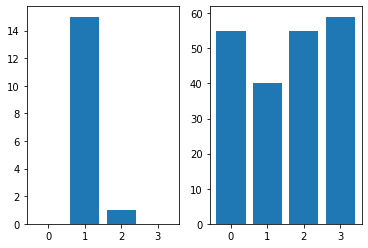

In [5]:
left_distribution, right_distribution = class_distributions(ytrain,ind_l,ind_r)
plt.subplot(1,2,1)
plt.bar(range(4), left_distribution)
plt.subplot(1,2,2)
plt.bar(range(4), right_distribution)

plt.show()

In [6]:
def entropy(y):
    return -sum([(y == i).sum() / len(y) * np.log2((y == i).sum() / len(y)) for i in range(np.max(ytrain)+1) if (y == i).sum() > 0])

def information_gain(ytrain, ind_left, ind_right):
    return entropy(ytrain) - (len(ind_left) / len(ytrain)) * entropy(ytrain[ind_left]) - (len(ind_right) / len(ytrain)) * entropy(ytrain[ind_right]) 
               
information_gain(ytrain, ind_l, ind_r)

0.13125029561477897

**f)** Create a function ***train*** to perfom a *randomized node optimization*. The function receives as parameters the full training dataset (Xtrain and ytrain) as well as the number of random stumps to try. The function will 
- generate the desired number of stumps, 
- split the dataset according to each stump, 
- evaluate the ***information gain*** for each split
- choose and then return the parameters of the best stump.

``` python
def train_stumps(Xtrain, ytrain, trials):
```

Print the progress of the information gain during the training process

**g)** Make predictions with the trained model and display the restuls

In [7]:
def train_stumps(Xtrain, ytrain, trials):
    best_information_gain = float('-inf')
    for _ in range(trials):
        f, t = stump(Xtrain)
        ind_l, ind_r = split(Xtrain, f, t)

        curr = information_gain(ytrain, ind_l, ind_r)
        if curr > best_information_gain:
            best_information_gain = curr
            f_best, t_best = f, t
            
    return f_best, t_best

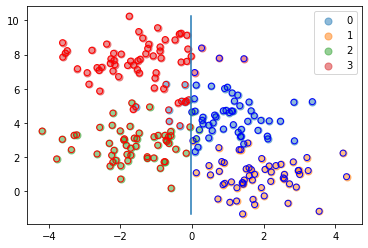

In [9]:
f, t = train_stumps(Xtrain, ytrain, 100)
ind_l, ind_r = split(Xtrain, f, t)
plot_stump (Xtrain,ytrain,f,t,ind_l,ind_r)

## 3. Comparing classifiers on the Caltech 101 dataset

Compare the performances of an SVM, a Decision Tree and Random Forest classifiers on the **Caltech 101** dataset for a binary classification task (e.g. dragonfly vs crayfish)


**a)** Load and split the dataset into train and test with 75% and 25% respective proportions

**b)** Train three classification models on the train dataset 
- an SVM
- a single decision tree ``sklearn.tree.DecisionTree``
- a Random Forest ``sklearn.ensemble.RandomForestClassifier``

Print the accuracy on the train and test sets for each model. ``from sklearn import metrics``

**c)** Plot the roc curves for each model, and compute the areas under the curve

**d)** Do a gridsearch with a 5-fold crossvalidation varying the hyperparameters of each model (e.g., for the SVM the ``kernel``, the ``gamma`` and ``c``, and for the tree-based models  ``max_depth``, ``max_features``, ``min_samples_leaf``, and ``n_estimators``).

``from sklearn.model_selection import GridSearchCV``

**Hint**
```
tuned_parameters = [{'max_depth': [1, 5, 10], 
                     'max_features': [1, 15, 30, 45, 60],
                     'n_estimators': [1, 25, 50, 75, 100],
                     'min_samples_leaf': [3,5,10]}]
                     
```
- What are the best parameters found to maximize the area under the curve in each case?

**e)** Discuss the results and curves.